# Image Registration and Combination using the JWST Level 3 Pipeline - MIRI example

Stage 3 image (Image3, calwebb_image3) processing is intended for combining the calibrated data from multiple exposures (e.g., a dither or mosaic pattern) into a single distortion corrected product. Before being combined, the exposures receive additional corrections for the purpose of astrometric alignment, background matching, and outlier rejection. 

> **Inputs**: The inputs to calwebb_image3 will usually be in the form of an association (ASN) file that lists multiple associated 2D calibrated exposures to be processed and combined into a single product. The individual exposures should be calibrated ("cal") from calwebb_image2 processing. It is also possible use a single "cal" file as input, in which case only the resample and source_catalog steps will be applied.

> **Outputs**: A resampled/rectified 2D image product with suffix "i2d" is created, containing the rectified single exposure or the rectified and combined association of exposures (the direct output of the resample step). A source catalog produced from the "i2d" product is saved as an ASCII file in "ecsv" format, with a suffix of "cat". If the outlier_detection step is applied, a new version of each input calibrated exposure product is created, which contains a DQ array that has been updated to flag pixels detected as outliers. This updated product is known as a CR-flagged product and the file is identified by including the association candidate ID in the original input "cal" file name and changing the suffix to "crf".
    

Level 3 pipeline steps:

**Tweakreg** (jwst.tweakreg, tweakreg_step, TweakRegStep)

**Sky Match** (jwst.skymatch, skymatch_step, SkyMatchStep)

**Outlier Detection** (jwst.outlier_detection, outlier_detection_step, OutlierDetectionStep)

**Resample** (jwst.resample, resample_step, ResampleStep)

**Source Catalog** (jwst.source_catalog, source_catalog_step, SourceCatalogStep)

(for more information on individual steps see: https://jwst-pipeline.readthedocs.io/en/latest/jwst/package_index.html)

### Table of Contents:
> * [Resources and Documentation](#resources)
> * [Create Association table](#association)
> * [Using Configuration Files](#pipeline_configs)
> * [Run Pipeline with Configuration Files](#pipeline_with_cfgs)
> * [Run Pipeline with Parameters Set Programmatically](#pipeline_no_configs)
> * [Run Individual Steps with Configuration Files](#steps_with_config_files)
> * [Run Individual Steps with Parameters Set Programmatically](#steps_no_configs)

***
<a id='resources'></a>
## 1. Resources and Documentation

There are several different places to find information on installing and running the pipeline. This notebook will give a shortened description of the steps pulled from the detailed pipeline information pages, but to find more in-depth instructions use the links below. 

>1. JDox: https://jwst-docs.stsci.edu/display/JDAT/JWST+Data+Reduction+Pipeline
>2. Installation page: http://astroconda.readthedocs.io/en/latest/releases.html#pipeline-install
>3. Detailed pipeline information: https://jwst-pipeline.readthedocs.io/en/latest/jwst/introduction.html
>4. Help Desk (click on Pipeline Support): https://stsci.service-now.com/jwst?id=sc_category
>5. GitHub README installation instructions: https://github.com/spacetelescope/jwst/blob/master/README.md


If this is your first time trying to run the pipeline from a jupyter notebook, you need to install the jupyter notebook in your pipeline environment:
>1. In a new terminal, change the directory to your working directory, terminal command: cd [your working directory]
>2. Terminal command: source activate jwst_dev
(or whatever your environment name for the pipeline is)
>3. Terminal command: conda install jupyter
>4. Terminal command: jupyter notebook


First, we must define environment variables for the CRDS server. This is necessary if you are not on the STScI internal network.

In [1]:
import os
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu/'
os.environ['CRDS_PATH'] = 'crds_cache'

In [2]:
import requests
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import LogStretch, ImageNormalize, ManualInterval
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Import pipeline
from jwst import datamodels
from jwst.pipeline import Image3Pipeline
# from jwst.associations.asn_from_list import asn_from_list  # perhaps can be done in the future

In [4]:
# Import individual pipeline steps
from jwst.tweakreg import tweakreg_step
from jwst.skymatch import skymatch_step
from jwst.outlier_detection import outlier_detection_step
from jwst.resample import resample_step
from jwst.source_catalog import source_catalog_step

### Loading Data

An example dataset to be used with this notebook is present in our Box repository. The cells below download:

1. The association file to be used as input to the pipeline
2. The fits files listed in the association file

### Download association file

### Download FITS files

### Octarine Redirected Download

In [5]:
URI_REDIRECTOR_SVC = "https://06own6zyx5.execute-api.us-east-1.amazonaws.com/nbfiles/"

def download(filename):
    """Download into the current working directory the lastest version of a box file
    referred to by ...
    
    Parameters
    ----------
    filename : str
        Human readable filename to be downloaded using URL redirector
        
    Returns
    -------
    filename : str
        Name of the downloaded file
    """
    url = URI_REDIRECTOR_SVC + filename
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise RuntimeError("Wrong URL - {}".format(url))
    # download_filename = response.headers['Content-Disposition'].split('"')[1]
    with open(filename, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    return filename

### Download Files For Notebook
1. The association file to be used as input to the pipeline
2. The fits files listed in the association file

In [6]:
association_file = "det_dithered_5stars.json"

FILES = [
    association_file,
    
    "det_image_1_MIRIMAGE_F770Wexp1_5stars_cal.fits",
    "det_image_1_MIRIMAGE_F770Wexp2_5stars_cal.fits",
    "det_image_2_MIRIMAGE_F770Wexp1_5stars_cal.fits",
    "det_image_2_MIRIMAGE_F770Wexp2_5stars_cal.fits",
]

# Grab a copy of the data used in this notebook from the Box repository
for filename in FILES:
    print(download(filename))

det_dithered_5stars.json
det_image_1_MIRIMAGE_F770Wexp1_5stars_cal.fits
det_image_1_MIRIMAGE_F770Wexp2_5stars_cal.fits
det_image_2_MIRIMAGE_F770Wexp1_5stars_cal.fits
det_image_2_MIRIMAGE_F770Wexp2_5stars_cal.fits


***
<a id='association'></a>
## 2. Create an Association Table

An association table is a **json** file that should contain all of the files to be combined in a single mosaic. Files that cannot be combined (e.g. NIRCam shortwave and longwave data) must be placed in separate association tables.

### An example association table

<a id='pipeline_configs'></a>
## 3. Using Configuration Files

Configuration files are optional inputs for each step of the pipeline, as well as for the pipeline itself. These files list step-specific parameters, and can also be used to control which steps are run as part of the pipeline.

You can get the full compliment of configuration files using the `collect_pipeline_cfgs` convenience function from the command line:

>`$ collect_pipeline_cfgs ./`

This creates a copy of all configuration files, for all steps and all JWST Instruments. Note that default parameters in the config files are not necessarily optimized for any particular instrument. 

Each of these configuration files can be customized to control pipeline behavior. For example, the configuration file for the Level 3 imaging pipeline is called **calwebb_image3.cfg** and contains a list (not necessarily in order) of the steps run as part of the Level 3 imaging pipeline.


    name = "Image3Pipeline"
    class = "jwst.pipeline.Image3Pipeline"

        [steps]
          [[tweakreg]]
            config_file = tweakreg.cfg
            skip = True
          [[skymatch]]
            config_file = skymatch.cfg
          [[outlier_detection]]
            config_file = outlier_detection.cfg
          [[resample]]
            config_file = resample.cfg
          [[source_catalog]]
            config_file = source_catalog.cfg
            save_results = true
        
In this example, the ***tweakreg*** step will be skipped (`skip = True`), and the output from the ***source_catalog*** step will be saved (`save_results = True`).

Note that **calwebb_image3.cfg** lists a configuration file for each pipeline step. You can customize a particular pipeline step by editing the parameters in its configuration file. For example, the source catalog configuration file, shown below, contains details on the kernel size and FWHM, as well as the signal to noise threshold to use in the identification of sources in the final combined image. 


    name = "source_catalog"
    class = "jwst.source_catalog.SourceCatalogStep"

    kernel_fwhm = 3.
    kernel_xsize = 5.
    kernel_ysize = 5.
    snr_threshold = 3.
    npixels = 50
    deblend = False

### Optional Config File Setup
To obtain config all config files in a "cfgs" directory execute the following cell:

In [7]:
!rm -rf cfgs
!collect_pipeline_cfgs cfgs

## 3.5 Running the pipeline on MIRI data

The dataset being used in this notebook is a set of four files, each with 5 point sources, two files each at two different dither positions. The files can be combined by running them through the pipeline. The final output catalog has one extra position listed, if everything is run with defaults. The files can be found at https://stsci.box.com/s/to6mcfmyap8kn7z9ordmcyb1dcbh1ps2. This repository also includes rate files (output of calwebb_detector1) and the cal files (output of calwebb_image2) as well as the files used to create the simulations in case those are helpful.

The association file is 'det_dithered_5stars.json' and has the following content:

The combined image is exported as: det_dithered_5stars_tweak_i2d.fits

***
<a id="pipeline_with_cfgs"></a>
## 4. Run Pipeline with Configuration Files

Once you have edited the configuration files to customize the Level 3 pipeline, the command below will run the pipeline.

This will generate a final source catalog ***cat.ecsv***, a final 2D image ***i2d.fits***, individual exposures with DQ array flagged for outliers ***crf.fits***, and blot images from the outlier detection step ***blot.fits***.

In [8]:
m = Image3Pipeline.call(association_file, config_file='cfgs/calwebb_image3.cfg')

2019-07-31 15:44:04,154 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2019-07-31 15:44:04,157 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2019-07-31 15:44:04,159 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2019-07-31 15:44:04,161 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2019-07-31 15:44:04,163 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2019-07-31 15:44:04,165 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2019-07-31 15:44:04,223 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('det_dithered_5stars.json',).
2019-07-31 15:44:05,637 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_1_MIRIMAGE_F770Wexp1_5stars_cal.fits' reftypes = ['drizpars']
2019-07-31 15:44:05,908 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is 'cr

2019-07-31 15:44:11,981 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_1_MIRIMAGE_F770Wexp1_5stars_cal.fits. Sky background: 0.0198634
2019-07-31 15:44:11,982 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_1_MIRIMAGE_F770Wexp2_5stars_cal.fits. Sky background: 0.0278488
2019-07-31 15:44:11,983 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_2_MIRIMAGE_F770Wexp1_5stars_cal.fits. Sky background: 0.00194469
2019-07-31 15:44:11,984 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_2_MIRIMAGE_F770Wexp2_5stars_cal.fits. Sky background: 0
2019-07-31 15:44:11,984 - stpipe.Image3Pipeline.skymatch - INFO -  
2019-07-31 15:44:11,985 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.
2019-07-31 15:44:12,026 - stpipe.Image3Pipeline.skymatch - INFO -  
2019-07-31 15:44:12,027 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 6.872292

### Examine Outputs

#### Combined Image

In [9]:
# Output combined image
combined_image_file = 'det_dithered_5stars_tweak_i2d.fits'
combined_image = fits.getdata(combined_image_file)

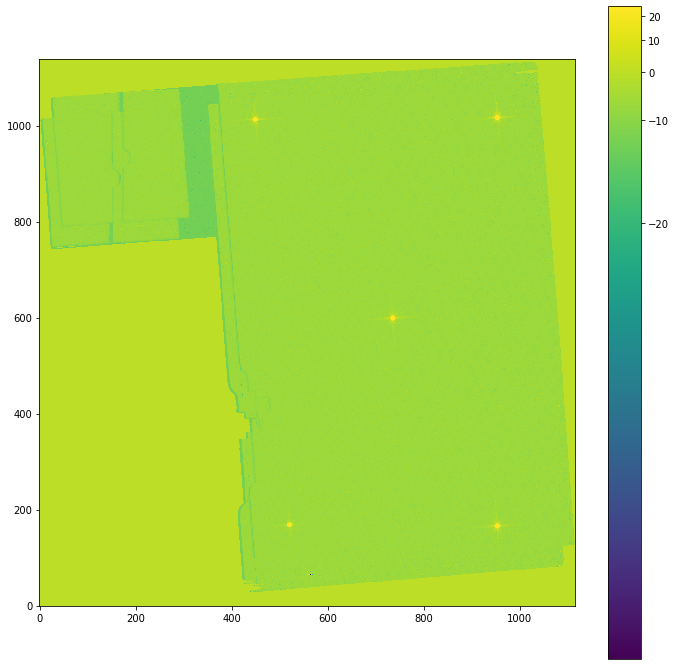

In [10]:
norm = ImageNormalize(combined_image, interval=ManualInterval(vmin=-25, vmax=25), stretch=LogStretch())
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(combined_image, origin='lower', norm=norm)
fig.colorbar(im)
plt.show()

***
<a id="pipeline_no_configs"></a>
## 5. Run Pipeline with Parameters Set Programmatically

You can also run the pipeline without relying on configuration files by setting parameters programmatically, and relying on the defaults in the pipeline.

In [11]:
m = Image3Pipeline()

# You can skip steps and change parameter values
m.tweakreg.skip = False
m.source_catalog.snr_threshold = 10
# run the pipeline with these parameters
m.run(association_file)

2019-07-31 15:44:28,827 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2019-07-31 15:44:28,830 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2019-07-31 15:44:28,832 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2019-07-31 15:44:28,835 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2019-07-31 15:44:28,837 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2019-07-31 15:44:28,839 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2019-07-31 15:44:28,919 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('det_dithered_5stars.json',).
2019-07-31 15:44:30,111 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_1_MIRIMAGE_F770Wexp1_5stars_cal.fits' reftypes = ['drizpars']
2019-07-31 15:44:30,114 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is 'cr

2019-07-31 15:44:36,418 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_1_MIRIMAGE_F770Wexp1_5stars_cal.fits. Sky background: 0.0198634
2019-07-31 15:44:36,419 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_1_MIRIMAGE_F770Wexp2_5stars_cal.fits. Sky background: 0.0278488
2019-07-31 15:44:36,419 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_2_MIRIMAGE_F770Wexp1_5stars_cal.fits. Sky background: 0.00194469
2019-07-31 15:44:36,420 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_2_MIRIMAGE_F770Wexp2_5stars_cal.fits. Sky background: 0
2019-07-31 15:44:36,422 - stpipe.Image3Pipeline.skymatch - INFO -  
2019-07-31 15:44:36,422 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.
2019-07-31 15:44:36,461 - stpipe.Image3Pipeline.skymatch - INFO -  
2019-07-31 15:44:36,461 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 6.872292

#### Combined Image

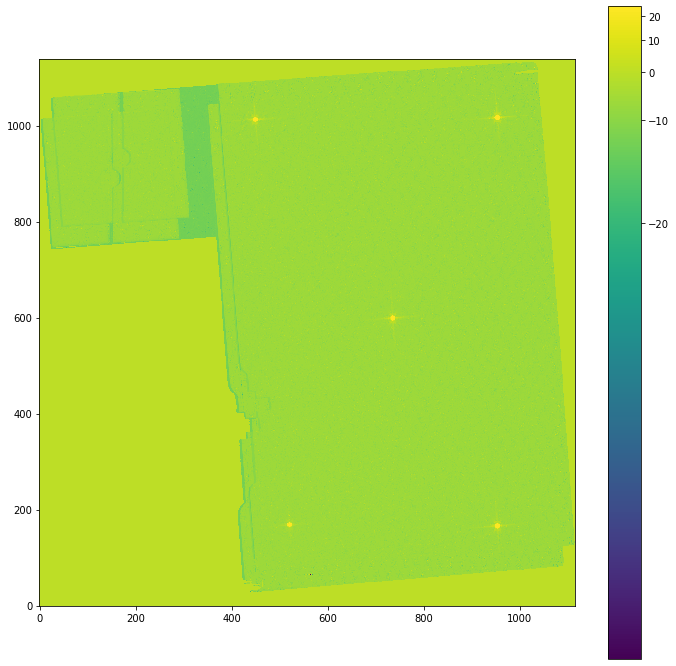

In [12]:
combined_image_file = 'det_dithered_5stars_tweak_i2d.fits' ## need to load data gain
combined_image = fits.getdata(combined_image_file) ## need to load data again
norm = ImageNormalize(combined_image, interval=ManualInterval(vmin=-25, vmax=25), stretch=LogStretch())
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(combined_image, origin='lower', norm=norm)
fig.colorbar(im)
plt.show()

***
<a id="steps_with_config_files"></a>
## 6. Run Individual Steps with Configuration Files

In [13]:
m = tweakreg_step.TweakRegStep.call(association_file, config_file='cfgs/tweakreg.cfg')
m = skymatch_step.SkyMatchStep.call(m, config_file='cfgs/skymatch.cfg')
m = outlier_detection_step.OutlierDetectionStep.call(m, config_file='cfgs/outlier_detection.cfg')
m = resample_step.ResampleStep.call(m, config_file='cfgs/resample.cfg', output_file='jw10002_short_step_by_step_i2d.fits')
m = source_catalog_step.SourceCatalogStep.call(m, config_file='cfgs/source_catalog.cfg', output_file='jw10002_short_step_by_step_cat.ecsv')

2019-07-31 15:44:52,805 - stpipe.tweakreg - INFO - TweakRegStep instance created.
2019-07-31 15:44:52,882 - stpipe.tweakreg - INFO - Step tweakreg running with args ('det_dithered_5stars.json',).
2019-07-31 15:44:54,523 - stpipe.tweakreg - INFO - Detected 18 sources in det_image_1_MIRIMAGE_F770Wexp1_5stars_cal.fits.
2019-07-31 15:44:54,890 - stpipe.tweakreg - INFO - Detected 9 sources in det_image_1_MIRIMAGE_F770Wexp2_5stars_cal.fits.
2019-07-31 15:44:55,264 - stpipe.tweakreg - INFO - Detected 17 sources in det_image_2_MIRIMAGE_F770Wexp1_5stars_cal.fits.
2019-07-31 15:44:55,613 - stpipe.tweakreg - INFO - Detected 22 sources in det_image_2_MIRIMAGE_F770Wexp2_5stars_cal.fits.
2019-07-31 15:44:56,406 - stpipe.tweakreg - INFO -  
2019-07-31 15:44:56,407 - stpipe.tweakreg - INFO - ***** jwst.tweakreg.imalign.align() started on 2019-07-31 15:44:56.406814
2019-07-31 15:44:56,408 - stpipe.tweakreg - INFO -  
2019-07-31 15:44:56,410 - stpipe.tweakreg - WARNING - Not enough sources to align imag

2019-07-31 15:45:04,418 - stpipe.outlier_detection - INFO - Blotting median...
2019-07-31 15:45:05,076 - stpipe.outlier_detection - INFO - Blotting (1024, 1032) <-- (1139, 1116)
2019-07-31 15:45:05,827 - stpipe.outlier_detection - INFO - Blotting (1024, 1032) <-- (1139, 1116)
2019-07-31 15:45:06,767 - stpipe.outlier_detection - INFO - Blotting (1024, 1032) <-- (1139, 1116)
2019-07-31 15:45:07,697 - stpipe.outlier_detection - INFO - Blotting (1024, 1032) <-- (1139, 1116)
2019-07-31 15:45:08,328 - stpipe.outlier_detection - INFO - Step outlier_detection done
2019-07-31 15:45:08,331 - stpipe.resample - INFO - ResampleStep instance created.
2019-07-31 15:45:08,422 - stpipe.resample - INFO - Step resample running with args (<ModelContainer>,).
2019-07-31 15:45:08,429 - stpipe.resample - INFO - Drizpars reference file: crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits
2019-07-31 15:45:08,989 - stpipe.resample - INFO - Blending metadata for det_dithered_5stars_tweak.fits
2019-07-31

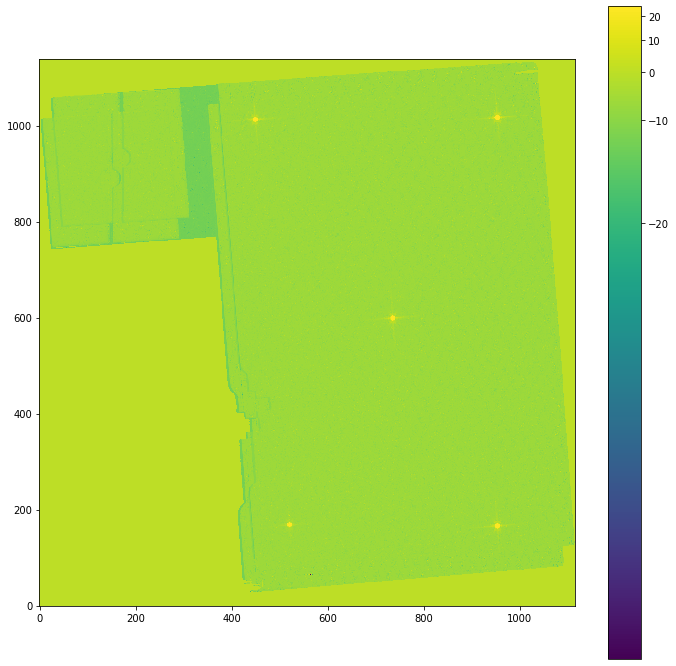

In [14]:
combined_image_file = 'det_dithered_5stars_tweak_i2d.fits' ## need to load data gain
combined_image = fits.getdata(combined_image_file) ## need to load data again
norm = ImageNormalize(combined_image, interval=ManualInterval(vmin=-25, vmax=25), stretch=LogStretch())
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(combined_image, origin='lower', norm=norm)
fig.colorbar(im)
plt.show()